In [121]:
!pip install imblearn
!pip install keras
!pip install xgboost
!pip install joblib

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.externals import joblib


from keras.layers import Dense
from keras.utils import to_categorical
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.utils import plot_model


In [180]:

df = pd.read_csv('orders.csv')

df['Cancel Time'] = df['Cancel Time'].fillna(np.nan)
df['Reject Time'] = df['Reject Time'].fillna(np.nan)


df['target'] = np.where( df['Cancel Time'].isnull(), 0, 1 )
df['target'] = np.where(df['Reject Time'].isnull(), df['target'], 1)



df['Cancel Time'] = pd.to_datetime(df['Cancel Time'])
df['Reject Time'] = pd.to_datetime(df['Reject Time'])

#for orders cancelled nby customer
df['Customer Hour'] = np.where(df['target'].isin([1]), df['Cancel Time'].dt.hour, np.nan)

df.columns

Index(['Available Drivers', 'Cancel Time', 'Order ID', 'Placed Time',
       'Reject Time', 'Response Distance', 'Response Time', 'Service Type',
       'target', 'Customer Hour'],
      dtype='object')

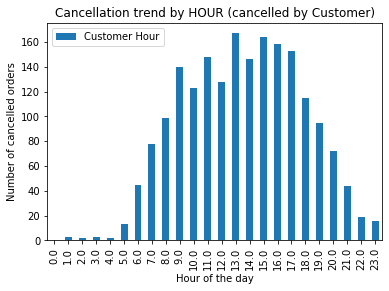

In [124]:

ax = df.groupby(['Customer Hour']).agg({'Customer Hour' : np.count_nonzero}).plot(kind='bar')
ax.set(xlabel='Hour of the day', ylabel='Number of cancelled orders', title='Cancellation trend by HOUR (cancelled by Customer)')
plt.show()
#for order cancelled by driver
df['Driver Hour'] = np.where(df['target'].isin([1]), df['Reject Time'].dt.hour, np.nan)


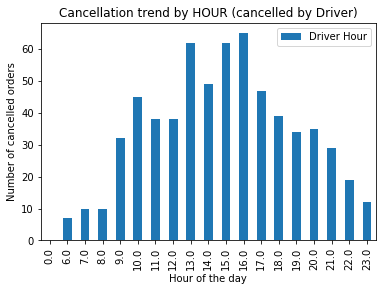

In [125]:

ax = df.groupby(['Driver Hour']).agg({'Driver Hour' : np.count_nonzero}).plot(kind='bar')
ax.set(xlabel='Hour of the day', ylabel='Number of cancelled orders', title='Cancellation trend by HOUR (cancelled by Driver)')
plt.show()


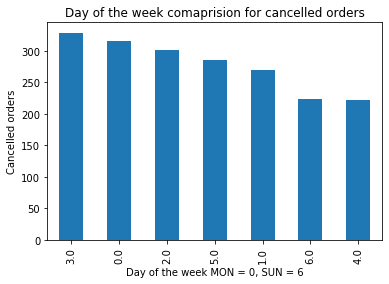

In [126]:
#day of the week
ax = df[df['target'].isin([1])]['Cancel Time'].dt.dayofweek.value_counts().plot(kind='bar')
ax.set(xlabel = 'Day of the week MON = 0, SUN = 6', ylabel='Cancelled orders', title='Day of the week comaprision for cancelled orders')
plt.show()


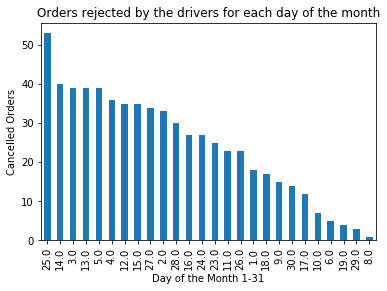

In [127]:
ax = df[df['target'].isin([1])]['Reject Time'].dt.day.value_counts().plot(kind='bar')
ax.set(xlabel='Day of the Month 1-31', ylabel='Cancelled Orders', title='Orders rejected by the drivers for each day of the month')
plt.show()


In [128]:
df['Placed Time'] = pd.to_datetime(df['Placed Time'])
#df['hour'] = df['Placed Time'].dt.hour
#df['day'] = df['Placed Time'].dt.dayofweek
#df['month'] = df['Placed Time'].dt.month
df['date'] = df['Placed Time'].dt.date


#check if weather has any effect on customer cancelleation 
#weather data taken from world weather online

w_df = pd.read_csv('hongkong.csv')
cols = ['date_time', 'tempC', 'windspeedKmph', 'visibility', 'cloudcover']
w_df = w_df[cols]

w_df['hour'] = pd.to_datetime(w_df['date_time']).dt.hour
w_df['day'] = pd.to_datetime(w_df['date_time']).dt.dayofweek
w_df['month'] = pd.to_datetime(w_df['date_time']).dt.month
w_df['date'] = pd.to_datetime(w_df['date_time']).dt.date

m_df = pd.merge(df, w_df, on=['date'], how='inner', indicator=True)


In [129]:
#Dimentionality reduction 
#lets check the variance 
cols = ['Available Drivers', 'Response Distance', 'Service Type', 'day', 'tempC', 'windspeedKmph', 'visibility', 'cloudcover']

df_var = m_df[cols]
df_var.var().sort_values(ascending=False)

#hour, visibility and tempreature have very less variance, however, lets see if we can find any pattern comparing them with order cancellation


Response Distance    1.502641e+07
Available Drivers    7.054183e+03
cloudcover           7.068276e+02
windspeedKmph        1.306433e+01
day                  3.671805e+00
tempC                2.063910e+00
visibility           4.052651e-01
dtype: float64

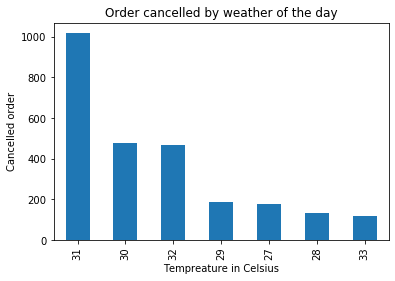

In [130]:

ax = m_df[m_df['target'].isin([1])]['tempC'].value_counts().plot(kind='bar')
ax.set(xlabel='Tempreature in Celsius', ylabel='Cancelled order', title='Order cancelled by weather of the day')
plt.show()

# 31 degrees have highest cancellation however we cant use that to predict the outcome but its a good to know information

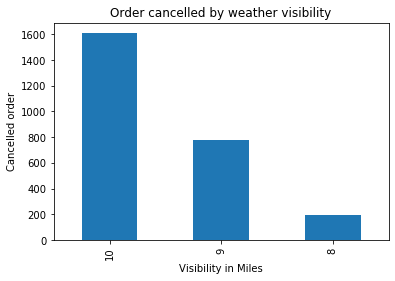

In [131]:


ax = m_df[m_df['target'].isin([1])]['visibility'].value_counts().plot(kind='bar')
ax.set(xlabel='Visibility in Miles', ylabel='Cancelled order', title='Order cancelled by weather visibility')
plt.show()

#similarly when the weather is clear the order cancellation tends to be the highest (informative but useless)

In [132]:
#lets check the correlation of each columns
cols = ['Available Drivers', 'Response Distance', 'Service Type', 'day', 'tempC', 'windspeedKmph', 'visibility', 'cloudcover']
df_corr = m_df[cols]
df_corr.corr()

#we can see that Tempreature and Visibility are highly correlated Hence dropping the visibility makes sense

,Available Drivers,Response Distance,day,tempC,windspeedKmph,visibility,cloudcover
Available Drivers,1.000000,-0.274463,-0.123332,0.113892,0.025432,0.105191,-0.184103
Response Distance,-0.274463,1.000000,0.046767,-0.009663,0.002502,0.006658,0.017727
day,-0.123332,0.046767,1.000000,-0.132066,0.071920,-0.162784,0.158578
tempC,0.113892,-0.009663,-0.132066,1.000000,0.029175,0.543099,-0.859508
windspeedKmph,0.025432,0.002502,0.071920,0.029175,1.000000,0.030350,-0.132042
visibility,0.105191,0.006658,-0.162784,0.543099,0.030350,1.000000,-0.583262
cloudcover,-0.184103,0.017727,0.158578,-0.859508,-0.132042,-0.583262,1.000000


In [133]:

def clean_data(df):
    
    y = df['target']
        
    cols = ['Available Drivers', 'Response Distance', 'Service Type', 'day', 'tempC', 'windspeedKmph', 'cloudcover']
    
    df = df[cols]
    
    #convert data types
    df['Service Type'] = df['Service Type'].map({'Van' : 1, 'Motorcycle' : 0})
    df['Response Distance'] = df['Response Distance'].round().fillna(0.0).astype(int)
    
    df['Response Distance'] = df['Response Distance'] / 100
    
    x = df[cols]
    
    #scale the data
    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    return x,y, cols


x , y, cols = clean_data(m_df)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

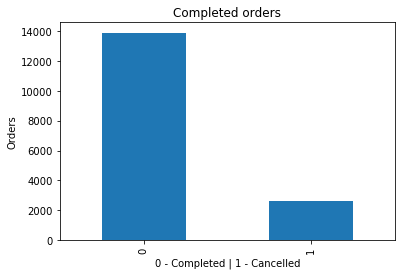

0    13898
1     2582
Name: target, dtype: int64


In [134]:
#lets check the data distribution here

ax = m_df.target.value_counts().plot(kind='bar')
ax.set(xlabel='0 - Completed | 1 - Cancelled', title='Completed orders', ylabel='Orders')
plt.show()
print(m_df.target.value_counts())

In [135]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.3)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


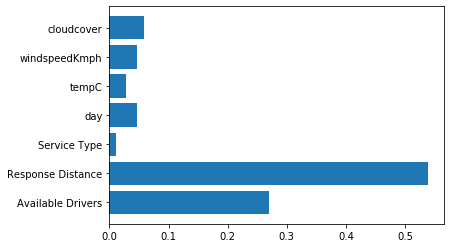

In [136]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model = model.fit(x_train, y_train)

cols = ['Available Drivers', 'Response Distance', 'Service Type', 'day', 'tempC', 'windspeedKmph', 'cloudcover']

imp_dict  = {k:v for k,v in zip(cols, model.feature_importances_)}
#print(model.feature_importances_)
plt.barh(range(len(imp_dict)), list(imp_dict.values()))
plt.yticks(range(len(imp_dict)), list(imp_dict.keys()))
plt.show()

#We can see that Response distance and available drivers have huge impact on outcome of the order

In [137]:
#fitting model just with 2 columns (response distance and available drivers)
def minified_df(m_df):
    
    y = m_df['target']
    x = m_df[['Available Drivers', 'Response Distance']]
    x['Response Distance'] = x['Response Distance'] / 100 
    x['Response Distance'] = x['Response Distance'].fillna(0.0)
    x = StandardScaler().fit_transform(x)

    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.3)
    
    return x_train, x_test, y_train, y_test

In [138]:
m_df.columns

Index(['Available Drivers', 'Cancel Time', 'Order ID', 'Placed Time',
       'Reject Time', 'Response Distance', 'Response Time', 'Service Type',
       'target', 'Customer Hour', 'Driver Hour', 'date', 'date_time', 'tempC',
       'windspeedKmph', 'visibility', 'cloudcover', 'hour', 'day', 'month',
       '_merge'],
      dtype='object')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


done


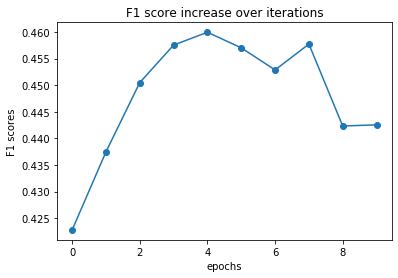

Its clear that highest F1 acheived is   46.0  percent with  Available drivers and Response distance Best SMOTE ratio was  0.5555555555555556
done


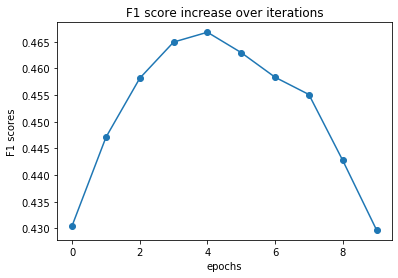

Its clear that highest F1 acheived is   47.0  percent with  All columns Best SMOTE ratio was  0.5555555555555556


In [139]:

def smote_results(x_train, y_train, cols):

    
    
    # smote with gridsearch
    clf = XGBClassifier()
    sm = SMOTE()
    ratios = np.linspace(0.20, 1, 10)

    pipe = make_pipeline(
    sm, clf
    )

    gsc = GridSearchCV(
        estimator=pipe,
        param_grid={

            'smote__ratio' : ratios
        },
            scoring='f1',
            cv=3
    )

    grid_result = gsc.fit(x_train, y_train)

    print('done')

    plt.plot(grid_result.cv_results_['mean_test_score'], marker='o')
    plt.xlabel('epochs')
    plt.ylabel('F1 scores')
    plt.title('F1 score increase over iterations')
    plt.show()

    return print('Its clear that highest F1 acheived is  ', round(grid_result.best_score_,2) * 100, ' percent with ', cols, 'Best SMOTE ratio was ', grid_result.best_params_['smote__ratio'])

m_x_train, m_x_test, m_y_train, m_y_test = minified_df(m_df)
smote_results(m_x_train, m_y_train, 'Available drivers and Response distance')





smote_results(x_train, y_train, 'All columns')


In [140]:
print('Best SMOTE score ', int(grid_result.best_params_['smote__ratio']))

Best SMOTE score  0


In [141]:
#XGB

x , y, cols = clean_data(m_df)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.3)

sm = SMOTE(ratio = .73)
x_train_rs, y_train_rs = sm.fit_sample(x_train, y_train)

clf = XGBClassifier().fit(x_train, y_train)

pred = clf.predict(x_test)

print(pd.crosstab(pred, y_test, rownames=['Predicted'], colnames=['Actual']))
print(classification_report(y_test, pred))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Actual        0    1
Predicted           
0          4156  527
1            48  213
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      4204
           1       0.82      0.29      0.43       740

    accuracy                           0.88      4944
   macro avg       0.85      0.64      0.68      4944
weighted avg       0.88      0.88      0.86      4944



In [165]:
#over sampling dint work, lets try undersampling

m_df_rand_0 = m_df[m_df['target'].isin([0])].index
m_df_rand_1 = m_df[m_df['target'].isin([1])].index

indexes = np.random.choice(m_df_rand_0, len(m_df_rand_1), replace=False)

data = np.concatenate([indexes, m_df_rand_1])

m_df_rand = m_df.loc[data]

print(m_df_rand.shape)

y = m_df_rand['target']

#minified dataframe 

print(m_df_rand.columns)

x , y, cols = clean_data(m_df_rand)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.3)

print(cols)

clf = XGBClassifier().fit(x_train, y_train)
pred = clf.predict(x_test)

print(pd.crosstab(pred, y_test, rownames=['Predicted'], colnames=['Acutal']))
print(classification_report(y_test, pred))

joblib.dump(clf, 'xgboost.pkl')



(5164, 21)
Index(['Available Drivers', 'Cancel Time', 'Order ID', 'Placed Time',
       'Reject Time', 'Response Distance', 'Response Time', 'Service Type',
       'target', 'Customer Hour', 'Driver Hour', 'date', 'date_time', 'tempC',
       'windspeedKmph', 'visibility', 'cloudcover', 'hour', 'day', 'month',
       '_merge'],
      dtype='object')
['Available Drivers', 'Response Distance', 'Service Type', 'day', 'tempC', 'windspeedKmph', 'cloudcover']
Acutal       0    1
Predicted          
0          685  362
1          111  392
              precision    recall  f1-score   support

           0       0.65      0.86      0.74       796
           1       0.78      0.52      0.62       754

    accuracy                           0.69      1550
   macro avg       0.72      0.69      0.68      1550
weighted avg       0.72      0.69      0.69      1550



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

['xgboost.pkl']

In [179]:
cols = ['Available Drivers', 'Response Distance', 'Service Type', 'day', 'tempC', 'windspeedKmph', 'cloudcover', 'target']

m_df_rand = m_df_rand[cols]

x = ['Available Drivers', 'Response Distance', 'Service Type', 'day', 'tempC', 'windspeedKmph', 'cloudcover']
x = m_df_rand[x]

y = m_df_rand['target']


print(m_df_rand['target'].value_counts())
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.3)

test_data_undersampled = pd.DataFrame(data=x_test, columns=cols)
test_data_undersampled = test_data_undersampled.drop(columns=['target'])
test_data_undersampled.to_csv('test_data_undersampled.csv')

test_data_target = pd.DataFrame(data=y_test, columns=['target'])
test_data_target.to_csv('test_target.csv', index=False)

test_data_undersampled.head()

1    2582
0    2582
Name: target, dtype: int64


,Available Drivers,Response Distance,Service Type,day,tempC,windspeedKmph,cloudcover
9555,13,4530.0,Van,2,31,5,13
10126,210,2908.0,Van,2,31,5,13
11639,50,2359.0,Motorcycle,5,32,13,17
9401,143,3502.0,Van,1,31,11,24
10313,312,1768.0,Van,2,31,5,13


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 100)               800       
_________________________________________________________________
dense_70 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_71 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_72 (Dense)             (None, 2)                 202       
Total params: 11,152
Trainable params: 11,152
Non-trainable params: 0
_________________________________________________________________
None
Train on 8075 samples, validate on 3461 samples
Epoch 1/50
8075/8075 [==============================] - 1s 91us/step - loss: 0.4360 - accuracy: 0.8448 - val_loss: 0.4105 - val_accuracy: 0.8431
Epoch 2/50
8075/8075 [===========================

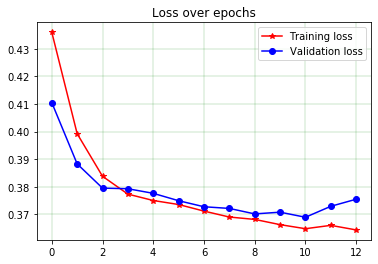

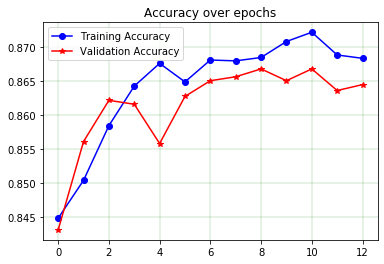

In [185]:
#using keras model



x , y, cols = clean_data(m_df)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.3)


model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(50, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())
model = model.fit(x_train, to_categorical(y_train), epochs=50, validation_split=0.3, batch_size=50, callbacks=[EarlyStopping(patience=2)])


# plot loss

plt.title('Loss over epochs')
plt.plot(model.history['loss'], marker='*', c='r')
plt.plot(model.history['val_loss'], marker='o', c='b')
plt.legend(['Training loss', 'Validation loss'])
plt.grid(color='g', linestyle='-', linewidth=0.2)
plt.show()

plt.title('Accuracy over epochs')
plt.plot(model.history['accuracy'], marker='o', c='b')
plt.plot(model.history['val_accuracy'], marker='*', c='r')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid(color='g', linestyle='-', linewidth=0.2)
plt.show()

